Step 1:
Preprocess the data. Selection/generation/ transformation of categorical variables, useful variables etc all your discretion.

Step 2:
Build your models: Please build classification models in Python to predict the Survived binary status assigned to a passenger. When writing the code associated with each model, please have the first part produce and save the model, followed by a second part that loads and applies the model.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

In [3]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Found unknown categories in columns"
)


In [4]:
MODEL_DIR = "saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [5]:
#data load
titanic_df = pd.read_csv('train.csv')
holdout_df = pd.read_csv('holdout_test.csv')

In [6]:
titanic_df.shape

(891, 12)

In [7]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
holdout_df.head()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,NaN,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,NaN,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,NaN,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
# Missing value
missing = titanic_df.isnull().sum()
missing_feature = missing[missing > 0].index.tolist()  
missing_pct = (missing / len(titanic_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

          Missing Count  Percentage
Cabin               687   77.104377
Age                 177   19.865320
Embarked              2    0.224467


In [12]:
# list of numerical variables
numerical_features = [feature for feature in titanic_df.columns if titanic_df[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
titanic_df[numerical_features].head()

Number of numerical variables:  7


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


In [13]:
#remove PassengerID
id_features = ['PassengerId']
numerical_features = [f for f in numerical_features if f not in id_features]

print(f"Numerical features (after removing ID): {numerical_features}")

Numerical features (after removing ID): ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [14]:
#list of categorical variables
categorical_features=[feature for feature in titanic_df.columns if titanic_df[feature].dtypes=='O']

print('Number of Categorical variables: ', len(categorical_features))
categorical_features


Number of Categorical variables:  5


['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Continuous features for outlier analysis: ['Age', 'Fare']


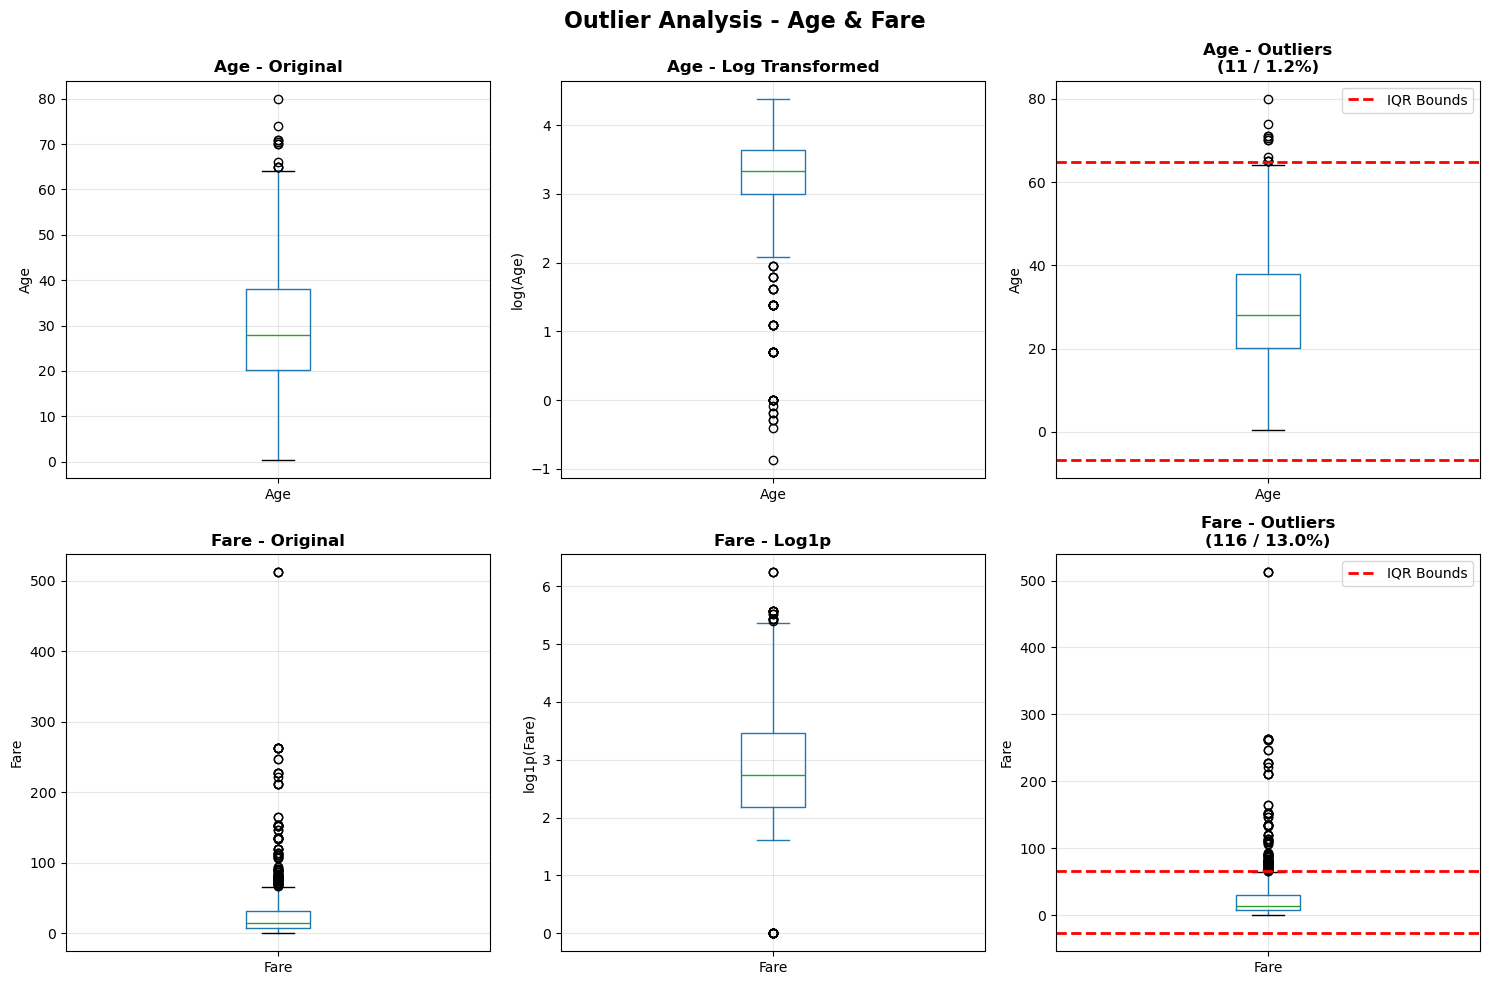

In [15]:
numerical_features = [
    feature for feature in titanic_df.columns 
    if titanic_df[feature].dtypes != 'O' 
    and feature != 'PassengerId'  
]

discrete_feature = [feature for feature in numerical_features 
                   if len(titanic_df[feature].unique()) < 25]

continuous_feature = [feature for feature in numerical_features 
                     if feature not in discrete_feature]

print(f"Continuous features for outlier analysis: {continuous_feature}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, feature in enumerate(continuous_feature):
    data = titanic_df.copy()
    
    # 1. Original Boxplot
    ax_idx = idx * 3
    data.boxplot(column=feature, ax=axes[ax_idx])
    axes[ax_idx].set_title(f'{feature} - Original', fontweight='bold')
    axes[ax_idx].set_ylabel(feature)
    axes[ax_idx].grid(True, alpha=0.3)
    
    # 2. Log Transformed
    ax_idx = idx * 3 + 1
    if 0 not in data[feature].unique() and data[feature].min() > 0:
        data_log = np.log(data[feature])
        data_log.plot.box(ax=axes[ax_idx])
        axes[ax_idx].set_title(f'{feature} - Log Transformed', fontweight='bold')
        axes[ax_idx].set_ylabel(f'log({feature})')
    else:
        data_log = np.log1p(data[feature])
        data_log.plot.box(ax=axes[ax_idx])
        axes[ax_idx].set_title(f'{feature} - Log1p', fontweight='bold')
        axes[ax_idx].set_ylabel(f'log1p({feature})')
    axes[ax_idx].grid(True, alpha=0.3)
    
    # 3. Outlier Bounds
    ax_idx = idx * 3 + 2
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    n_outliers = len(outliers)
    pct = n_outliers / len(data) * 100
    
    data.boxplot(column=feature, ax=axes[ax_idx])
    axes[ax_idx].axhline(lower_bound, color='red', linestyle='--', 
                        linewidth=2, label='IQR Bounds')
    axes[ax_idx].axhline(upper_bound, color='red', linestyle='--', linewidth=2)
    axes[ax_idx].set_title(f'{feature} - Outliers\n({n_outliers} / {pct:.1f}%)', 
                          fontweight='bold')
    axes[ax_idx].set_ylabel(feature)
    axes[ax_idx].legend()
    axes[ax_idx].grid(True, alpha=0.3)

for i in range(len(continuous_feature) * 3, 6):
    fig.delaxes(axes[i])

plt.suptitle('Outlier Analysis - Age & Fare', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [16]:
#OUTLIER STATISTICS

for feature in continuous_feature:
    Q1 = titanic_df[feature].quantile(0.25)
    Q3 = titanic_df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = titanic_df[
        (titanic_df[feature] < lower_bound) | 
        (titanic_df[feature] > upper_bound)
    ]
    
    print(f"\n{feature}:")
    print(f"  Min: {titanic_df[feature].min():.2f}")
    print(f"  Q1:  {Q1:.2f}")
    print(f"  Median: {titanic_df[feature].median():.2f}")
    print(f"  Q3:  {Q3:.2f}")
    print(f"  Max: {titanic_df[feature].max():.2f}")
    print(f"  IQR Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(titanic_df)*100:.1f}%)")
    
    if len(outliers) > 0 and len(outliers) <= 10:
        print(f"  Outlier values: {sorted(outliers[feature].values)}")


Age:
  Min: 0.42
  Q1:  20.12
  Median: 28.00
  Q3:  38.00
  Max: 80.00
  IQR Bounds: [-6.69, 64.81]
  Outliers: 11 (1.2%)

Fare:
  Min: 0.00
  Q1:  7.91
  Median: 14.45
  Q3:  31.00
  Max: 512.33
  IQR Bounds: [-26.72, 65.63]
  Outliers: 116 (13.0%)


#### Target variable Analysis

 Survival Rate
Survived
0    549
1    342
Name: count, dtype: int64

Overall Survival Rate: 38.38%


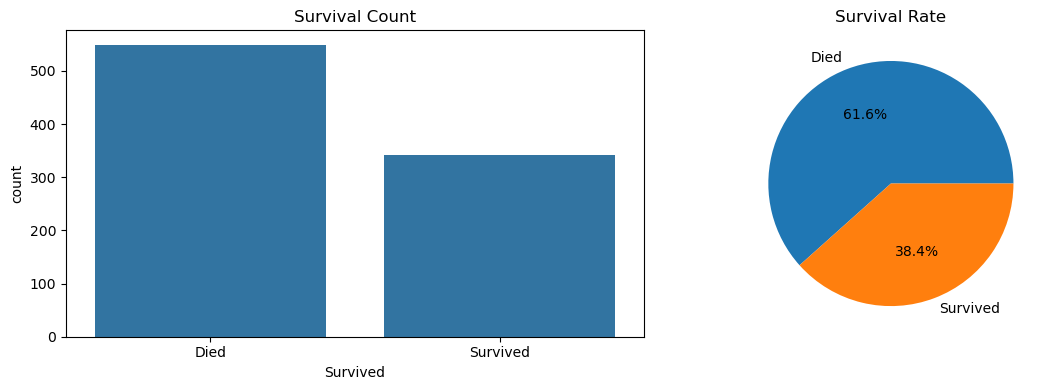

In [17]:
#Survival Rate
print(" Survival Rate")
print(titanic_df['Survived'].value_counts())
print(f"\nOverall Survival Rate: {titanic_df['Survived'].mean():.2%}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
sns.countplot(data=titanic_df, x='Survived', ax=axes[0])
axes[0].set_title('Survival Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Died', 'Survived'])

# Pie chart
titanic_df['Survived'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    labels=['Died', 'Survived'],
    ax=axes[1]
)
axes[1].set_title('Survival Rate')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


--- Survival Rate by Pclass ---
            mean  count
Pclass                 
1       0.629630    216
2       0.472826    184
3       0.242363    491

--- Survival Rate by Sex ---
            mean  count
Sex                    
female  0.742038    314
male    0.188908    577

--- Survival Rate by Embarked ---
              mean  count
Embarked                 
C         0.553571    168
Q         0.389610     77
S         0.336957    644

--- Survival Rate by SibSp ---
           mean  count
SibSp                 
0      0.345395    608
1      0.535885    209
2      0.464286     28
3      0.250000     16
4      0.166667     18
5      0.000000      5
8      0.000000      7

--- Survival Rate by Parch ---
           mean  count
Parch                 
0      0.343658    678
1      0.550847    118
2      0.500000     80
3      0.600000      5
4      0.000000      4
5      0.200000      5
6      0.000000      1


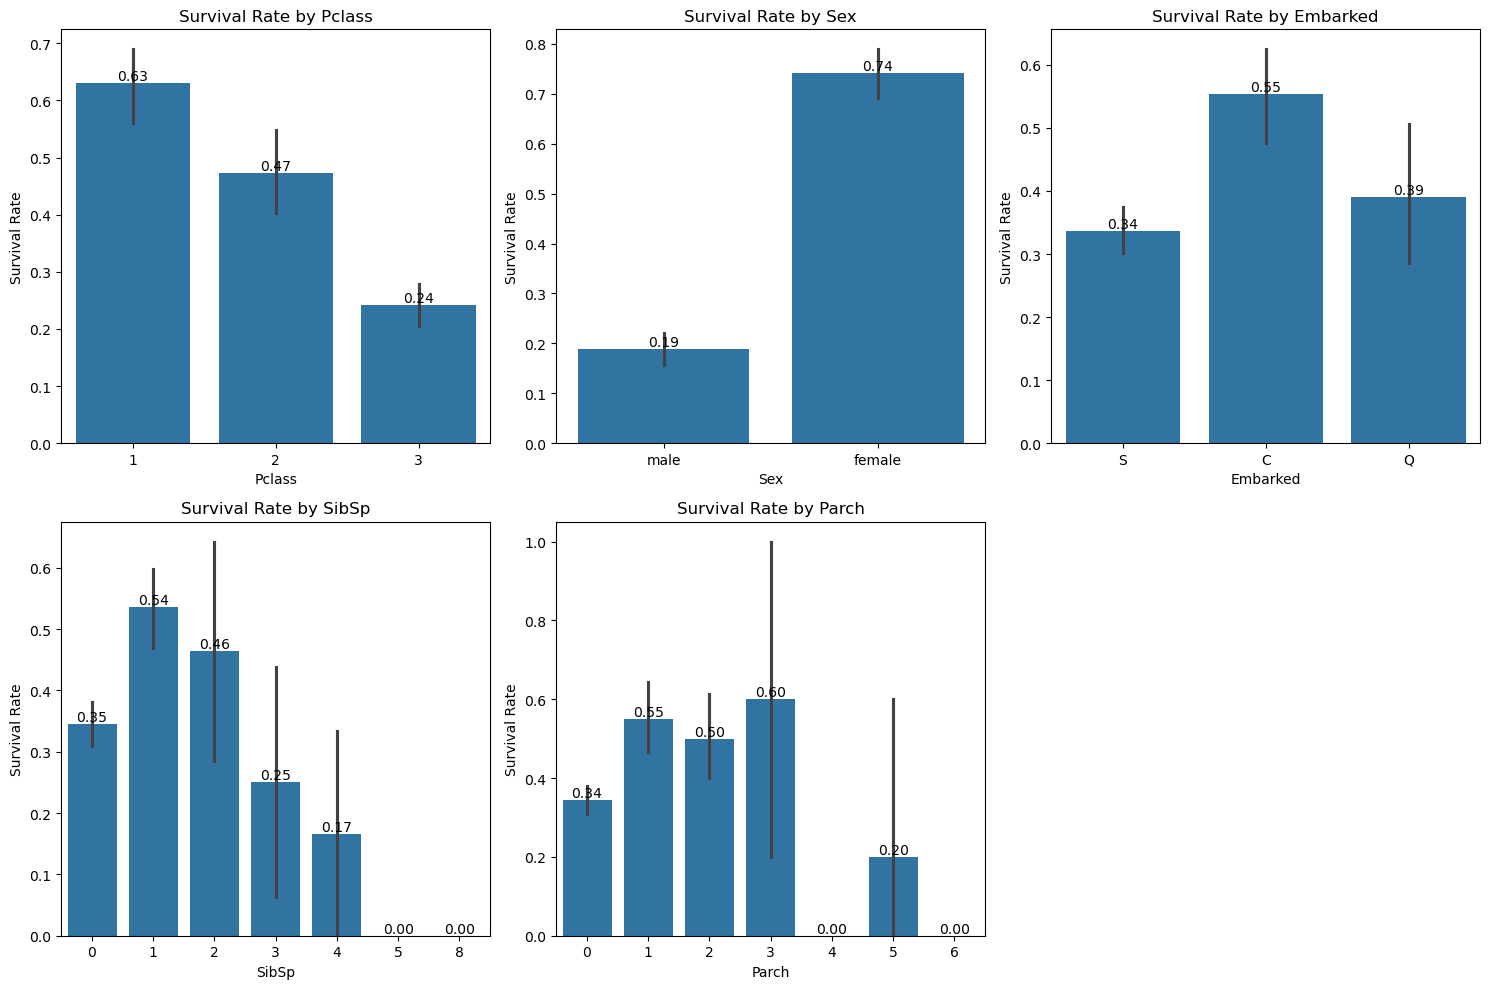

In [18]:
categorical_vars = ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, var in enumerate(categorical_vars):
    survival_rate = titanic_df.groupby(var)['Survived'].agg(['mean', 'count'])
    print(f"\n--- Survival Rate by {var} ---")
    print(survival_rate)
    
    sns.barplot(data=titanic_df, x=var, y='Survived', ax=axes[idx])
    axes[idx].set_title(f'Survival Rate by {var}')
    axes[idx].set_ylabel('Survival Rate')
    
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.2f')

plt.delaxes(axes[5])  
plt.tight_layout()
plt.show()


Survival rate for female is higher than male.
Survival rate for SibSp, Parch is 



Survival Rate by Sex and Pclass
Pclass         1         2         3
Sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447


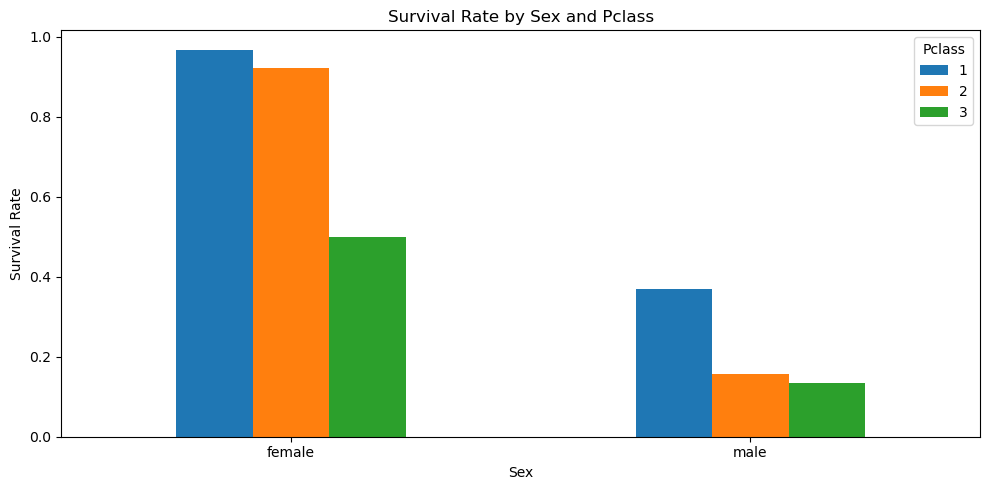

In [19]:
#Survival Rate by Sex and Pclass
print("\nSurvival Rate by Sex and Pclass")

survival_by_sex_class = titanic_df.groupby(['Sex', 'Pclass'])['Survived'].mean().unstack()
print(survival_by_sex_class)

survival_by_sex_class.plot(kind='bar', figsize=(10, 5))
plt.title('Survival Rate by Sex and Pclass')
plt.ylabel('Survival Rate')
plt.xlabel('Sex')
plt.xticks(rotation=0)
plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

The results clearly reflect the “women and children first” principle during the Titanic rescue process. Female passengers had significantly higher survival rates than male passengers across all passenger classes. This suggests that women were given priority during evacuation.

Social class also had a strong impact on survival. First-class passengers had much higher survival rates compared to third-class passengers. Since first-class cabins were located on the upper decks, they likely had easier access to lifeboats, while third-class passengers were located on lower decks, making escape more difficult. This indicates that socioeconomic status influenced survival outcomes.

The worst survival combination was third-class males, with a survival rate of about 13.5%. They were both lower in evacuation priority and physically located farther from lifeboats.
In contrast, first- and second-class females had survival rates above 90%, meaning that the majority of them survived. Overall, both gender and passenger class played a critical role in determining survival on the Titanic.

Survival Rate by Sex and SibSp
SibSp          0         1         2         3         4    5    8
Sex                                                               
female  0.787356  0.754717  0.769231  0.363636  0.333333  0.0  0.0
male    0.168203  0.310680  0.200000  0.000000  0.083333  0.0  0.0


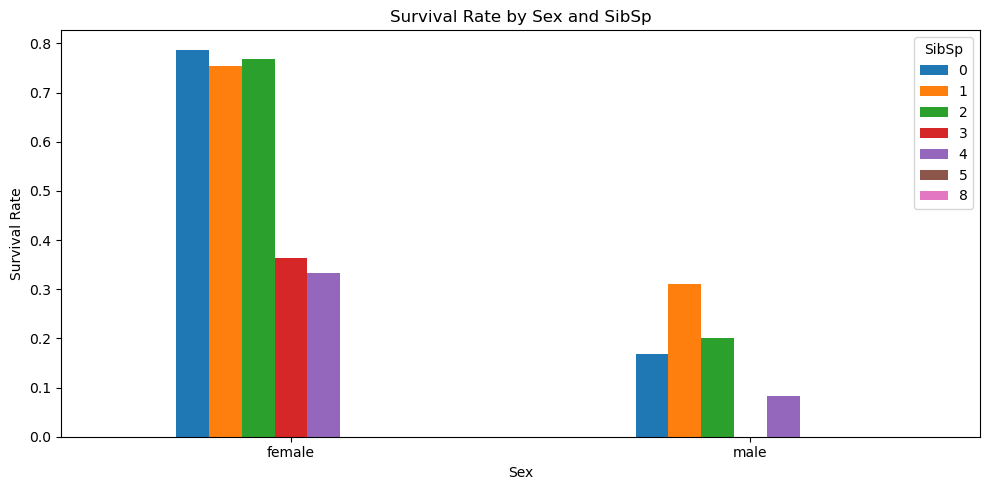

In [20]:
#Survival Rate by Sex and SibSp
print("Survival Rate by Sex and SibSp")
survival_by_sex_class = titanic_df.groupby(['Sex', 'SibSp'])['Survived'].mean().unstack()
print(survival_by_sex_class)

survival_by_sex_class.plot(kind='bar', figsize=(10, 5))
plt.title('Survival Rate by Sex and SibSp')
plt.ylabel('Survival Rate')
plt.xlabel('Sex')
plt.xticks(rotation=0)
plt.legend(title='SibSp')
plt.tight_layout()
plt.show()

The results show that survival rates differ depending on whether passengers were traveling alone or with family members. In general, females had higher survival rates than males regardless of family size. However, the number of siblings/spouses aboard (SibSp) also appears to influence survival outcomes.

Passengers traveling alone (SibSp = 0) had different survival patterns compared to those traveling with one or two family members. For females, survival rates were relatively high when traveling with a small number of family members (0–2), but decreased as family size increased. For males, survival rates were generally low across all categories, though those with one sibling/spouse had slightly higher survival than those traveling alone.

Interestingly, very large families (e.g., SibSp ≥ 5 or 8) had extremely low survival rates. This may be due to the difficulty of coordinating and evacuating large groups during the chaotic rescue process. Overall, family size appears to have influenced survival, with moderate family sizes potentially offering some advantage, but very large families facing disadvantages.

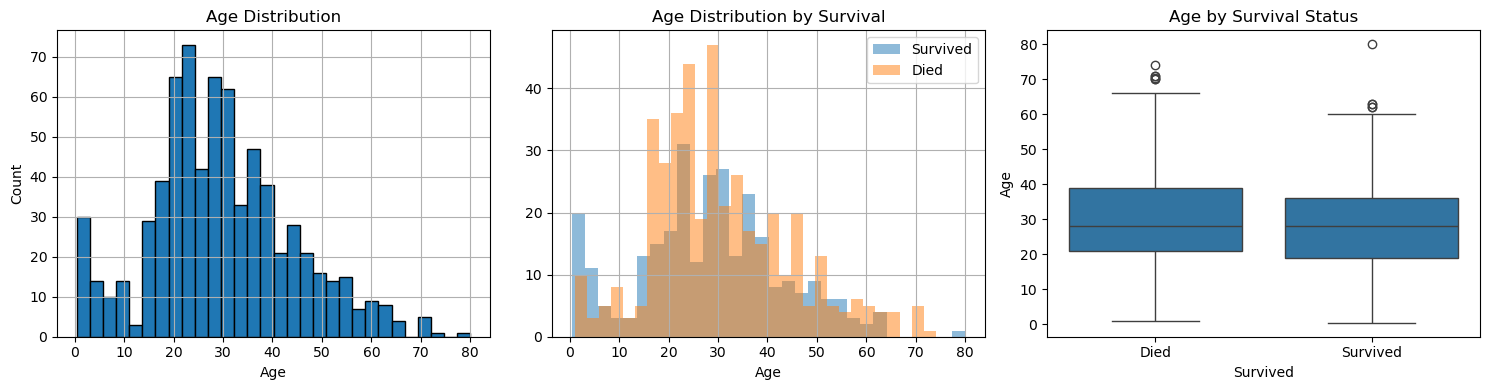


Age Statistics by Survival:
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0


In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

titanic_df['Age'].hist(bins=30, ax=axes[0], edgecolor='black')
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

titanic_df[titanic_df['Survived']==1]['Age'].hist(bins=30, alpha=0.5, label='Survived', ax=axes[1])
titanic_df[titanic_df['Survived']==0]['Age'].hist(bins=30, alpha=0.5, label='Died', ax=axes[1])
axes[1].set_title('Age Distribution by Survival')
axes[1].set_xlabel('Age')
axes[1].legend()

sns.boxplot(data=titanic_df, x='Survived', y='Age', ax=axes[2])
axes[2].set_title('Age by Survival Status')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Died', 'Survived'])

plt.tight_layout()
plt.show()

print("\nAge Statistics by Survival:")
print(titanic_df.groupby('Survived')['Age'].describe())

First, the overall age distribution shows that most passengers were between their early 20s and late 30s. There are relatively fewer very young children and elderly passengers. The distribution is slightly right-skewed, with a small number of older individuals above age 60.

Looking at the age distribution by survival, we can see some differences between those who survived and those who did not. Younger passengers appear to have slightly higher survival rates compared to older passengers. There are visibly more children among the survivors, which supports the historical “women and children first” evacuation principle.

The boxplot further confirms that survivors tend to be slightly younger on average than those who died. However, the difference is not extremely large, suggesting that age alone was not the strongest determining factor. Compared to gender and passenger class, age appears to have a moderate but not dominant effect on survival.

Overall, while younger passengers had somewhat better chances of survival, factors such as gender and class likely played a more significant role in determining outcomes.

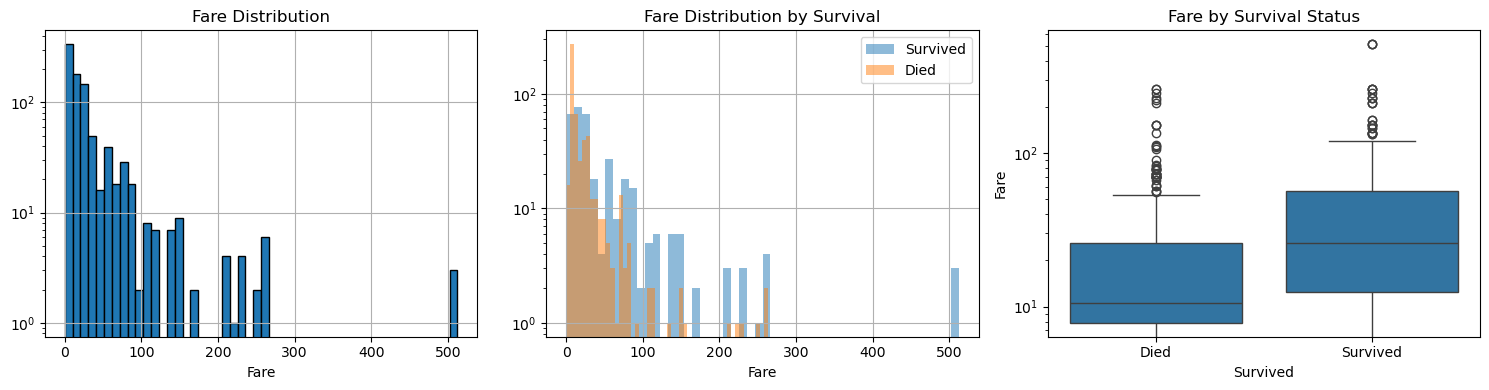


Fare Statistics by Survival:
          count       mean        std  min      25%   50%   75%       max
Survived                                                                 
0         549.0  22.117887  31.388207  0.0   7.8542  10.5  26.0  263.0000
1         342.0  48.395408  66.596998  0.0  12.4750  26.0  57.0  512.3292


In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

titanic_df['Fare'].hist(bins=50, ax=axes[0], edgecolor='black')
axes[0].set_title('Fare Distribution')
axes[0].set_xlabel('Fare')
axes[0].set_yscale('log')

titanic_df[titanic_df['Survived']==1]['Fare'].hist(bins=50, alpha=0.5, label='Survived', ax=axes[1])
titanic_df[titanic_df['Survived']==0]['Fare'].hist(bins=50, alpha=0.5, label='Died', ax=axes[1])
axes[1].set_title('Fare Distribution by Survival')
axes[1].set_xlabel('Fare')
axes[1].set_yscale('log')
axes[1].legend()

sns.boxplot(data=titanic_df, x='Survived', y='Fare', ax=axes[2])
axes[2].set_title('Fare by Survival Status')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Died', 'Survived'])
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print("\nFare Statistics by Survival:")
print(titanic_df.groupby('Survived')['Fare'].describe())

The overall fare distribution is highly right-skewed. Most passengers paid relatively low fares, while a small number of passengers paid extremely high fares. This explains why the y-axis is shown on a log scale.

When comparing fare by survival status, survivors generally paid higher fares than those who died. The mean fare for survivors (about 48.4) is more than double the mean fare for non-survivors (about 22.1). The median also shows a noticeable difference, indicating that higher-paying passengers had better chances of survival.

The boxplot further confirms that survivors tend to have higher fare values, and there are many high-fare outliers among survivors. This suggests that fare, which is closely related to passenger class and socioeconomic status, played an important role in survival.

Overall, passengers who paid higher fares were significantly more likely to survive, reinforcing the impact of social class on survival outcomes.


Before Title Mapping
Unique titles: 17
Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

After Title Mapping
Unique titles: 5
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

Survival Rate by Title
            mean  count
Title                  
Mrs     0.793651    126
Miss    0.702703    185
Master  0.575000     40
Rare    0.347826     23
Mr      0.156673    517


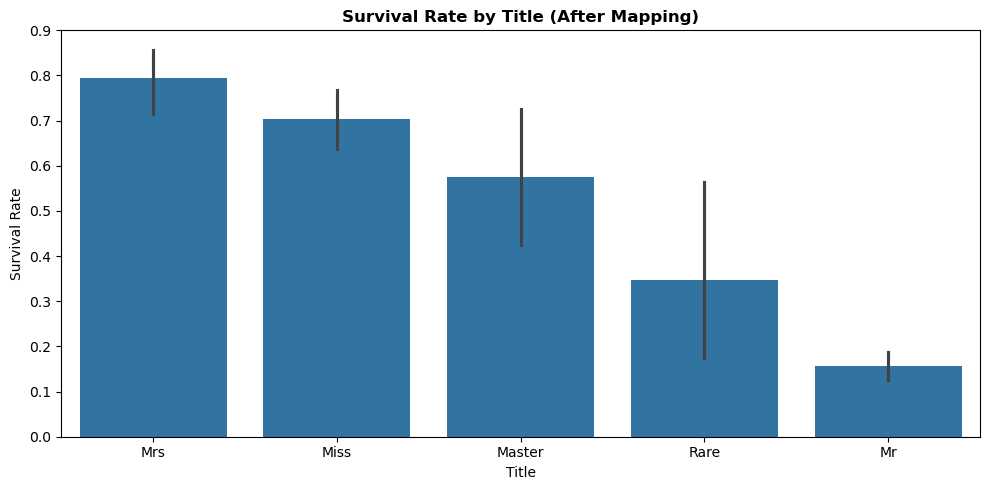

In [23]:
#title mapping
def extract_title(name):
    """Getting title from the name"""
    return name.split(',')[1].split('.')[0].strip()

titanic_df['Title'] = titanic_df['Name'].apply(extract_title)


print("\nBefore Title Mapping")
print(f"Unique titles: {titanic_df['Title'].nunique()}")
print(titanic_df['Title'].value_counts())

title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Mlle': 'Miss',      
    'Ms': 'Miss',
    'Mme': 'Mrs',        
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Major': 'Rare',
    'Countess': 'Rare',
    'Lady': 'Rare',
    'Sir': 'Rare',
    'Jonkheer': 'Rare',
    'Don': 'Rare',
    'Dona': 'Rare',
    'Capt': 'Rare'
}

titanic_df['Title'] = titanic_df['Title'].map(title_mapping)
titanic_df['Title'] = titanic_df['Title'].fillna('Rare')  # Unknown → Rare

print("\nAfter Title Mapping")
print(f"Unique titles: {titanic_df['Title'].nunique()}")
print(titanic_df['Title'].value_counts())


print("\nSurvival Rate by Title")
title_survival = titanic_df.groupby('Title')['Survived'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(title_survival)

plt.figure(figsize=(10, 5))
sns.barplot(data=titanic_df, x='Title', y='Survived', 
            order=['Mrs', 'Miss', 'Master', 'Rare', 'Mr']) 
plt.title('Survival Rate by Title (After Mapping)', fontweight='bold')
plt.ylabel('Survival Rate')
plt.xlabel('Title')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Correlation Analysis


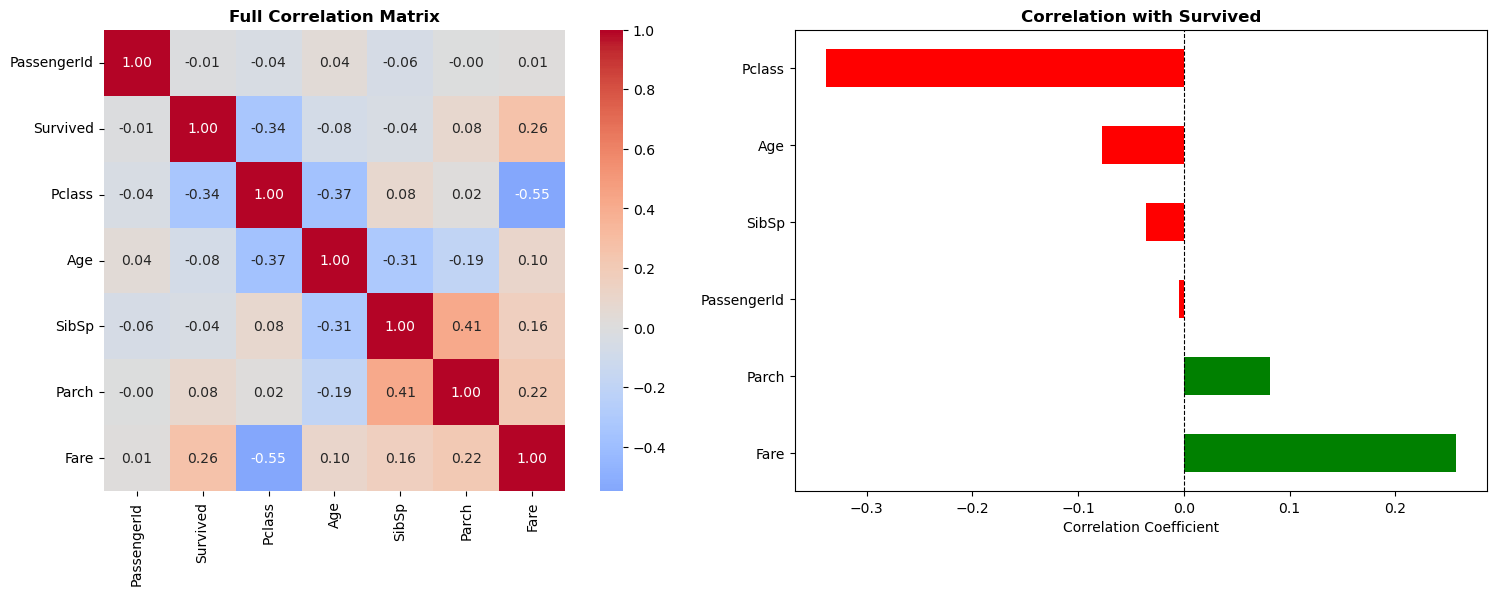


Top correlations with Survived:
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Name: Survived, dtype: float64


In [24]:
print("\nCorrelation Analysis")

numeric_cols = titanic_df.select_dtypes(include=['int64', 'float64']).columns
correlation = titanic_df[numeric_cols].corr()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[0], square=True)
axes[0].set_title('Full Correlation Matrix', fontweight='bold', fontsize=12)

survived_corr = correlation['Survived'].drop('Survived').sort_values(ascending=False)
survived_corr.plot(kind='barh', ax=axes[1], color=['green' if x > 0 else 'red' for x in survived_corr])
axes[1].set_title('Correlation with Survived', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Correlation Coefficient')
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

print("\nTop correlations with Survived:")
print(survived_corr.head(5))

### Missing Values

MISSING VALUE vs SURVIVAL RATE

Age:
  Has Value (0):  40.62% survival
  Missing (1):    29.38% survival
  Difference:     11.24%


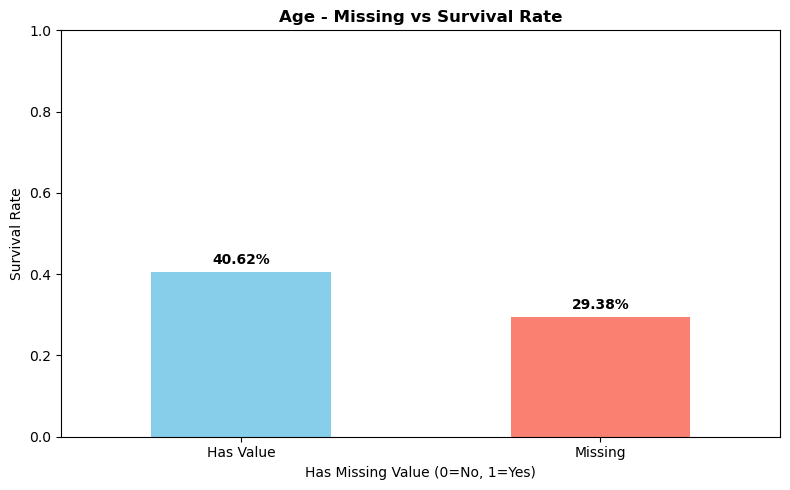


Cabin:
  Has Value (0):  66.67% survival
  Missing (1):    29.99% survival
  Difference:     36.68%


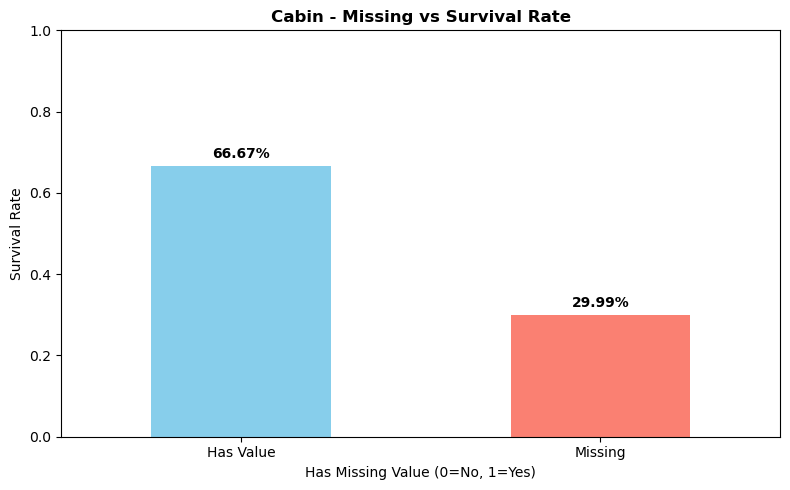


Embarked:
  Has Value (0):  38.25% survival
  Missing (1):    100.00% survival
  Difference:     61.75%


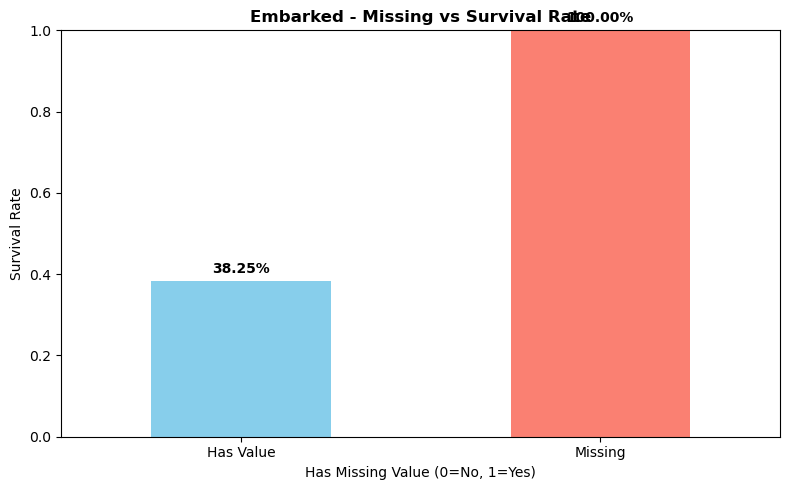

In [25]:
# Relationship between missing values and target
print("MISSING VALUE vs SURVIVAL RATE")

features_with_na = missing_feature  

for feature in features_with_na:
    has_missing = titanic_df[feature].isnull().astype(int)
    
    survival_by_missing = titanic_df.groupby(has_missing)['Survived'].mean()
    
    print(f"\n{feature}:")
    print(f"  Has Value (0):  {survival_by_missing.get(0, 0):.2%} survival")
    print(f"  Missing (1):    {survival_by_missing.get(1, 0):.2%} survival")
    print(f"  Difference:     {abs(survival_by_missing.get(0, 0) - survival_by_missing.get(1, 0)):.2%}")
    
    plt.figure(figsize=(8, 5))
    survival_by_missing.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title(f'{feature} - Missing vs Survival Rate', fontweight='bold')
    plt.xlabel('Has Missing Value (0=No, 1=Yes)')
    plt.ylabel('Survival Rate')
    plt.xticks([0, 1], ['Has Value', 'Missing'], rotation=0)
    plt.ylim(0, 1)
    
    for i, v in enumerate(survival_by_missing):
        plt.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [26]:
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs


#### Age
Passengers with recorded age information had a survival rate of 40.62%, while those with missing age values had a lower survival rate of 29.38%. The difference of over 11% suggests that missing age is not random.
One possible explanation is that passengers whose ages were recorded were likely better documented and possibly belonged to higher passenger classes (first or second class). In contrast, passengers without recorded age information may have been third-class passengers, where record-keeping was less systematic.
This suggests that missing age may indirectly capture socioeconomic status. Therefore, instead of simply imputing missing age values, it may be useful to create a new binary feature such as HasAge, since the missingness itself appears informative.

#### Cabin
The difference is even more striking for Cabin. Passengers with a recorded cabin number had a survival rate of 66.67%, while those without a cabin number had only 29.99% survival.
This strongly suggests that having a cabin number is associated with higher socioeconomic status (likely first- or second-class passengers). These passengers were located on upper decks, closer to lifeboats, which likely increased their chances of survival.
Therefore, missing Cabin values do not simply mean “data is unavailable,” but may indicate lower-class passengers. Creating a feature such as HasCabin would likely improve predictive performance.

#### Embarked
For Embarked, the missing values show a 100% survival rate. However, this is likely due to a very small number of missing cases (only two passengers). Both appear to belong to higher socioeconomic status groups.
Since the sample size is extremely small, this missingness is probably not meaningful. Imputing these values (e.g., filling with the most common port, 'S') is reasonable.

#### Overall Insight
Missing values in this dataset are not purely random noise. In particular, Cabin and Age missingness appear to contain socioeconomic information. Rather than blindly imputing these values, it may be beneficial to create indicator variables capturing whether the information was originally missing.

In [27]:
# Imputation - missing value for Embarked
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('S')

In [28]:
# HasCabin
titanic_df['HasCabin'] = titanic_df['Cabin'].notnull().astype(int)

In [29]:
# Cabin_letter
titanic_df['Cabin'] = titanic_df['Cabin'].fillna('N')
titanic_df['Cabin_letter'] = titanic_df['Cabin'].str[0]
titanic_df = titanic_df.drop(columns=['Cabin'])

In [30]:
# Age_Missing
titanic_df['Age_Missing'] = titanic_df['Age'].isnull().astype(int)

In [31]:
# Imputation - inserting age by title
age_by_title = titanic_df.groupby('Title')['Age'].median()

print("Median Age by Title:")
for title, age in age_by_title.items():
    print(f"  {title:8s}: {age:.1f} years")


for title in titanic_df['Title'].unique():
    median_age = age_by_title[title]
    titanic_df.loc[
        (titanic_df['Age'].isnull()) & (titanic_df['Title'] == title),
        'Age'
    ] = median_age

print(f"\nAge missing after: {titanic_df['Age'].isnull().sum()}")

Median Age by Title:
  Master  : 3.5 years
  Miss    : 21.0 years
  Mr      : 30.0 years
  Mrs     : 35.0 years
  Rare    : 48.5 years

Age missing after: 0


In [32]:
# Adding new features
# FamilySize
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1
print(f"FamilySize created (range: {titanic_df['FamilySize'].min()}-{titanic_df['FamilySize'].max()})")

# IsAlone
titanic_df['IsAlone'] = (titanic_df['FamilySize'] == 1).astype(int)
print(f"IsAlone created (alone: {titanic_df['IsAlone'].sum()}, with family: {(1-titanic_df['IsAlone']).sum()})")

# AgeGroup
titanic_df['AgeGroup'] = pd.cut(
    titanic_df['Age'], 
    bins=[0, 12, 18, 35, 60, 100],
    labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior']
)
print(f"AgeGroup created:")
print(titanic_df['AgeGroup'].value_counts())

# FarePerPerson
titanic_df['FarePerPerson'] = titanic_df['Fare'] / titanic_df['FamilySize']
titanic_df['FarePerPerson'] = titanic_df['FarePerPerson'].fillna(titanic_df['FarePerPerson'].median())
print(f"FarePerPerson created (median: {titanic_df['FarePerPerson'].median():.2f})")

FamilySize created (range: 1-11)
IsAlone created (alone: 537, with family: 354)
AgeGroup created:
AgeGroup
Adult     530
Middle    196
Child      73
Teen       70
Senior     22
Name: count, dtype: int64
FarePerPerson created (median: 8.30)


In [33]:
# Survival Rates by New Features
print("\nSurvival Rates by New Features")

print("\nFamilySize:")
print(titanic_df.groupby('FamilySize')['Survived'].mean().sort_values(ascending=False))

print("\nIsAlone:")
print(titanic_df.groupby('IsAlone')['Survived'].mean())

print("\nAgeGroup:")
titanic_df.groupby('AgeGroup', observed=False)['Survived'].mean()



Survival Rates by New Features

FamilySize:
FamilySize
4     0.724138
3     0.578431
2     0.552795
7     0.333333
1     0.303538
5     0.200000
6     0.136364
8     0.000000
11    0.000000
Name: Survived, dtype: float64

IsAlone:
IsAlone
0    0.505650
1    0.303538
Name: Survived, dtype: float64

AgeGroup:


AgeGroup
Child     0.575342
Teen      0.428571
Adult     0.352830
Middle    0.397959
Senior    0.227273
Name: Survived, dtype: float64

In [34]:
print("\nFinal Feature Summary")

feature_columns = [
    'Pclass', 'Sex', 'Age', 'Fare', 'Embarked',
    'SibSp', 'Parch',
    'Title', 'AgeGroup',
    'FamilySize', 'IsAlone', 'FarePerPerson',
    'Cabin_letter', 'HasCabin',
    'Age_Missing'
]

print(f"\nTotal features: {len(feature_columns)}")
print("\nFeature types:")
print(f"  Original: 7")
print(f"  Engineered: 7")

missing_final = titanic_df[feature_columns].isnull().sum()
if missing_final.sum() == 0:
    print("\nNo missing values in features")
else:
    print(f"\nStill have missing values:")
    print(missing_final[missing_final > 0])



Final Feature Summary

Total features: 15

Feature types:
  Original: 7
  Engineered: 7

No missing values in features


In [35]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Name           891 non-null    object  
 4   Sex            891 non-null    object  
 5   Age            891 non-null    float64 
 6   SibSp          891 non-null    int64   
 7   Parch          891 non-null    int64   
 8   Ticket         891 non-null    object  
 9   Fare           891 non-null    float64 
 10  Embarked       891 non-null    object  
 11  Title          891 non-null    object  
 12  HasCabin       891 non-null    int64   
 13  Cabin_letter   891 non-null    object  
 14  Age_Missing    891 non-null    int64   
 15  FamilySize     891 non-null    int64   
 16  IsAlone        891 non-null    int64   
 17  AgeGroup       891 non-null    cate

### Handling imbalanced datasets

In [36]:
print(titanic_df['Survived'].value_counts())

Survived
0    549
1    342
Name: count, dtype: int64


In [37]:
survived_pct = titanic_df['Survived'].value_counts(normalize=True)
print("\nPercentage")
for label, pct in survived_pct.items():
    print(f"{label}: {pct:.2%}")

# Imbalance ratio
ratio = survived_pct[0] / survived_pct[1]
print(f"\nImbalance Ratio (Died/Survived): {ratio:.2f}")

if ratio > 1.5 or ratio < 0.67:
    print("Class imbalance detected")
    print("Strategy: Use class_weight='balanced' in models")
else:
    print("Classes are relatively balanced")


Percentage
0: 61.62%
1: 38.38%

Imbalance Ratio (Died/Survived): 1.61
Class imbalance detected
Strategy: Use class_weight='balanced' in models


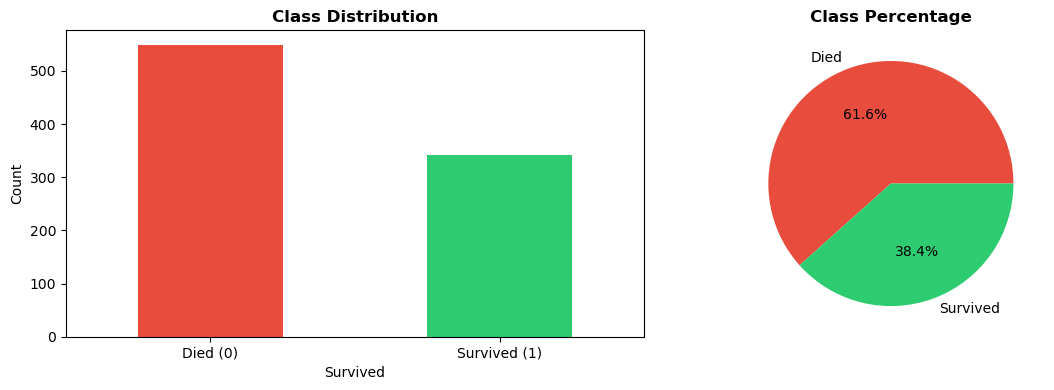

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

titanic_df['Survived'].value_counts().plot(kind='bar', ax=axes[0], 
                                           color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Class Distribution', fontweight='bold')
axes[0].set_xticklabels(['Died (0)', 'Survived (1)'], rotation=0)
axes[0].set_ylabel('Count')

survived_pct.plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                  labels=['Died', 'Survived'], colors=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('')
axes[1].set_title('Class Percentage', fontweight='bold')

plt.tight_layout()
plt.show()

In [39]:
#Checking feature scaling

print("\nCurrent Feature Ranges")

numerical_features = [
    'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
    'FamilySize', 'IsAlone', 'HasCabin', 'Age_Missing'
]

print("\nFeature          Min        Max       Range")
print("-" * 55)
for feature in numerical_features:
    if feature in titanic_df.columns:
        min_val = titanic_df[feature].min()
        max_val = titanic_df[feature].max()
        range_val = max_val - min_val
        print(f"{feature:15s} {min_val:8.1f}  {max_val:9.1f}  {range_val:9.1f}")



Current Feature Ranges

Feature          Min        Max       Range
-------------------------------------------------------
Pclass               1.0        3.0        2.0
Age                  0.4       80.0       79.6
SibSp                0.0        8.0        8.0
Parch                0.0        6.0        6.0
Fare                 0.0      512.3      512.3
FamilySize           1.0       11.0       10.0
IsAlone              0.0        1.0        1.0
HasCabin             0.0        1.0        1.0
Age_Missing          0.0        1.0        1.0


Need StandardScaler in pipeline later

In [40]:
#Categorical 
categorical_features = titanic_df.select_dtypes(include=['object']).columns.tolist()

for feature in categorical_features:
    n_unique = titanic_df[feature].nunique()
    print(f"{feature:15s}: {n_unique} unique values")
    print(f"  → {titanic_df[feature].value_counts().head(3).to_dict()}")


Name           : 891 unique values
  → {'Braund, Mr. Owen Harris': 1, 'Boulos, Mr. Hanna': 1, 'Frolicher-Stehli, Mr. Maxmillian': 1}
Sex            : 2 unique values
  → {'male': 577, 'female': 314}
Ticket         : 681 unique values
  → {'347082': 7, 'CA. 2343': 7, '1601': 7}
Embarked       : 3 unique values
  → {'S': 646, 'C': 168, 'Q': 77}
Title          : 5 unique values
  → {'Mr': 517, 'Miss': 185, 'Mrs': 126}
Cabin_letter   : 9 unique values
  → {'N': 687, 'C': 59, 'B': 47}


Sex, Embarked, Title, Cabin_letter need to change it to values

In [41]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PassengerId    891 non-null    int64   
 1   Survived       891 non-null    int64   
 2   Pclass         891 non-null    int64   
 3   Name           891 non-null    object  
 4   Sex            891 non-null    object  
 5   Age            891 non-null    float64 
 6   SibSp          891 non-null    int64   
 7   Parch          891 non-null    int64   
 8   Ticket         891 non-null    object  
 9   Fare           891 non-null    float64 
 10  Embarked       891 non-null    object  
 11  Title          891 non-null    object  
 12  HasCabin       891 non-null    int64   
 13  Cabin_letter   891 non-null    object  
 14  Age_Missing    891 non-null    int64   
 15  FamilySize     891 non-null    int64   
 16  IsAlone        891 non-null    int64   
 17  AgeGroup       891 non-null    cate

### Train model

In [42]:
#Feature selection
feature_columns = [
    # Original numerical
    'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
    
    # Original categorical
    'Sex', 'Embarked',
    
    # Engineered
    'Title', 'FamilySize', 'IsAlone',
    'HasCabin', 'Cabin_letter', 'Age_Missing'
]

print(f"Selected {len(feature_columns)} features:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")

Selected 13 features:
   1. Pclass
   2. Age
   3. SibSp
   4. Parch
   5. Fare
   6. Sex
   7. Embarked
   8. Title
   9. FamilySize
  10. IsAlone
  11. HasCabin
  12. Cabin_letter
  13. Age_Missing


In [43]:
# X, y separation
X = titanic_df[feature_columns].copy()
y = titanic_df['Survived'].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (891, 13)
y shape: (891,)


In [44]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [45]:
print(f"Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nTrain survival rate: {y_train.mean():.2%}")
print(f"Test survival rate:  {y_test.mean():.2%}")

Train: 712 samples (79.9%)
Test:  179 samples (20.1%)

Train survival rate: 38.34%
Test survival rate:  38.55%


In [46]:
# Feature types
numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
                      'FamilySize', 'IsAlone', 'HasCabin', 'Age_Missing']

categorical_features = ['Sex', 'Embarked', 'Title', 'Cabin_letter']

print(f"Numerical ({len(numerical_features)}): {numerical_features}")
print(f"Categorical ({len(categorical_features)}): {categorical_features}")

Numerical (9): ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'HasCabin', 'Age_Missing']
Categorical (4): ['Sex', 'Embarked', 'Title', 'Cabin_letter']


In [47]:
# Model Training
# preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [48]:
models = {
    'LogisticRegression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'DecisionTree': DecisionTreeClassifier(
        random_state=42,
        max_depth=5,
        class_weight='balanced'
    ),
    'RandomForest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=5,
        class_weight='balanced'
    ),
    'GradientBoosting': GradientBoostingClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1
    )
}

In [49]:
# Train
results = []

for name, classifier in models.items():
    print(f"Training {name}...")
    
    # Full pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    # Save
    model_path = f"{MODEL_DIR}/{name.lower()}_model.joblib"
    joblib.dump(model, model_path)

Training LogisticRegression...
  Accuracy:  0.8212
  Precision: 0.7534
  Recall:    0.7971
  F1-Score:  0.7746
Training DecisionTree...
  Accuracy:  0.7933
  Precision: 0.6905
  Recall:    0.8406
  F1-Score:  0.7582
Training RandomForest...
  Accuracy:  0.7989
  Precision: 0.7089
  Recall:    0.8116
  F1-Score:  0.7568
Training GradientBoosting...
  Accuracy:  0.8156
  Precision: 0.8103
  Recall:    0.6812
  F1-Score:  0.7402


### holdout data

In [50]:
holdout_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     0 non-null      float64
 1   PassengerId  418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 39.3+ KB


In [51]:
holdout_df.head()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,NaN,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,NaN,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,NaN,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [52]:
def preprocess_holdout_safe(holdout_df, age_by_title, global_age_median, global_fare_median):
    df = holdout_df.copy()
    
    # Title: Extract and map
    if 'Title' not in df.columns:
        if 'Name' in df.columns:
            # Extract title
            df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
        else:
            df['Title'] = 'Unknown'
    
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Countess': 'Rare', 'Lady': 'Rare', 'Sir': 'Rare',
        'Jonkheer': 'Rare', 'Don': 'Rare', 'Dona': 'Rare', 'Capt': 'Rare'
    }
    df['Title'] = df['Title'].map(title_mapping).fillna('Rare')
    
    # Embarked
    if 'Embarked' not in df.columns:
        df['Embarked'] = 'S'
    df['Embarked'] = df['Embarked'].fillna('S')
    
    # Cabin features
    if 'Cabin' not in df.columns:
        df['Cabin'] = np.nan
    df['HasCabin'] = df['Cabin'].notna().astype(int)
    df['Cabin_letter'] = df['Cabin'].fillna('N').astype(str).str[0]
    
    # Age
    if 'Age' not in df.columns:
        df['Age'] = np.nan
    df['Age_Missing'] = df['Age'].isna().astype(int)
    
    # Fill Age by Title
    for title in df['Title'].dropna().unique():
        fill_value = age_by_title.get(title, global_age_median)
        df.loc[df['Age'].isna() & (df['Title'] == title), 'Age'] = fill_value
    df['Age'] = df['Age'].fillna(global_age_median)

    # Fare
    if 'Fare' not in df.columns:
        df['Fare'] = np.nan
    df['Fare'] = df['Fare'].fillna(global_fare_median)

    # Family features
    if 'SibSp' not in df.columns:
        df['SibSp'] = 0
    if 'Parch' not in df.columns:
        df['Parch'] = 0
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    return df

In [54]:
age_by_title = titanic_df.groupby('Title')['Age'].median().to_dict()
global_age_median = titanic_df['Age'].median()
global_fare_median = titanic_df['Fare'].median()

holdout_df = preprocess_holdout_safe(holdout_df, age_by_title, global_age_median, global_fare_median)

missing = set(feature_columns) - set(holdout_df.columns)
print("Missing engineered cols after preprocess:", missing)

Missing engineered cols after preprocess: set()


In [55]:
holdout_df.head()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasCabin,Cabin_letter,Age_Missing,FamilySize,IsAlone
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0,N,0,1,1
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,0,N,0,2,0
2,NaN,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0,N,0,1,1
3,NaN,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0,N,0,1,1
4,NaN,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,0,N,0,3,0


In [56]:
#predict survived
best_model_name = "LogisticRegression"  
best_model_path = f"{MODEL_DIR}/{best_model_name.lower()}_model.joblib"

best_model = joblib.load(best_model_path)

In [57]:
X_holdout = holdout_df[feature_columns].copy()
holdout_pred = best_model.predict(X_holdout).astype(int)

In [58]:
submission = pd.DataFrame({"Survived": holdout_pred})
submission.to_csv("Titanic Results from sieonlee.csv", index=False)
print("Saved:", "Titanic Results from sieonlee.csv")


Saved: Titanic Results from sieonlee.csv


### Final Write-up
I compared four classification models to predict Titanic survival: Logistic Regression, Decision Tree, Random Forest, and Gradient Boosting. Logistic Regression achieved the highest overall accuracy (0.821) and strong F1-score (0.775), demonstrating good balance between precision and recall while maintaining interpretability and computational efficiency. Decision Tree showed the highest recall (0.841), meaning it identified more actual survivors, but at the cost of lower precision and potential overfitting. Random Forest provided more stable performance than a single tree by reducing variance through ensemble learning, though its overall metrics were slightly lower than Logistic Regression. Gradient Boosting achieved the highest precision (0.810), indicating strong ability to correctly predict survivors, but its lower recall reduced overall F1 performance. Based on overall balance between accuracy, precision, and F1-score, Logistic Regression was selected as the final model due to its strong generalization performance and interpretability.